# KDM5C cis comparison

KDM5C encodes a protein that has five domains. Two domains are zinc fingers (DNA-binding motifs) and suggest that this protein is involved with regulating transcription and chromatin remodeling. See NCBI's webpage for more information: https://www.ncbi.nlm.nih.gov/gene/8242

## Step 1: Library Imports

Run this cell to import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import re
import sys 
sys.path.append('C:\\Users\\brittany henderson\\GitHub\\WhenMutationsMatter\\Brittany\\')
import functions as f

import cptac
import cptac.algorithms as al

In [243]:
def format_pval_annotation(pval_symbol, x1, x2, line_start = .05, line_height=.05):
    
    #x1, x2 = -.25, 0  # columns (first column: 0, see plt.xticks())
    y, h = line_start, line_height
    plt.plot([x1, x1, x2, x2], #draw horizontal line
             [y, y+h, y+h, y], #vertical line
             lw=1.5, color= '.3')
    plt.text((x1+x2)*.5, # half between x coord
             y+h, pval_symbol, horizontalalignment='center', verticalalignment='bottom', color = "black")

In [2]:
def wrap_ttest_return_all(df, label_column, comparison_columns, total_tests=1, alpha=.05):
    try:
        #Verify precondition that label column exists and has exactly 2 unique values
        label_values = df[label_column].unique()
        if len(label_values) != 2:
            print("Incorrectly Formatted Dataframe! Label column must have exactly 2 unique values.")
            return None
        
        #Partition dataframe into two sets, one for each of the two unique values from the label column
        partition1 = df.loc[df[label_column] == label_values[0]]
        partition2 = df.loc[df[label_column] == label_values[1]]
        
        #Determine the number of real valued columns on which we will do t-tests
        #sites = len(comparison_columns.columns)
        number_of_comparisons = total_tests # ? phospho sites or num freq mut genes doing cis comp
        
        #Use a bonferroni correction to adjust for multiple testing by altering the p-value needed for acceptance
        bonferroni_cutoff = alpha/number_of_comparisons
        
        #Store all comparisons with their p-values in a dictionary
        all_comparisons = {}
        
        #Loop through each comparison column, perform the t-test, and determine whether it meets the significance cutoff'''
        for column in comparison_columns:
            stat, pval = scipy.stats.ttest_ind(partition1[column].dropna(axis=0), partition2[column].dropna(axis=0))
            all_comparisons[column] = pval
    
        #Sort dictionary to list smallest p-values first
        sorted_comparisons = sorted(all_comparisons.items(), key=lambda kv: kv[1])
        #Format as a dataframe and return to caller
        all_comparisons_df = pd.DataFrame.from_dict(sorted_comparisons)
        all_comparisons_df.columns = ['Comparison', 'P_Value']
        
                                               
        all_comparisons_sig_col = f.add_significance_col(all_comparisons_df, number_of_comparisons)
        return all_comparisons_sig_col
                                
    except:
        print("Incorrectly Formatted Dataframe!")
        return None


## Step 2: Find the mutation frequency of KDM5C for Kidney Cancer

In [3]:
cancer = cptac.RenalCcrcc()
desired_cutoff = 0.1
gene = 'KDM5C'

freq_mut = al.get_frequently_mutated(cancer, cutoff = desired_cutoff)
freq_mut.loc[freq_mut['Gene'] == gene]

,Gene,Unique_Samples_Mut,Missense_Mut,Truncation_Mut
1,KDM5C,0.172727,0.036364,0.145455


## Step 3: cis comparisons for omics 

Determine if the DNA mutation has an effect on the omics measurement. In order to do this, we have a few steps in code. These steps are found in the format_cis_comparison_data function.
1. get a table with both the omics and mutation data for tumors
2. get a binary column from the mutation data to separate our samples
3. format data frame to be used in the T-test
4. send data to the T-test.

The format_cis_comparison_data does the first 3 steps.

# Proteomics cis comparison

Proteomics: Mutated and Wildtype


In [4]:
# prepare for wrap_ttest_return_all
cis_tests = len(freq_mut) # adjust for multiple hypothesis testing (other genes compared in separate notebooks)

prot_col_list = [gene+'_proteomics']
prot_mut_status = f.format_cis_comparison_data(cancer, 'proteomics', gene)


In [5]:
# Step 4 - T-test comparing means of mutated vs wildtype effect on cis omics
print("Doing t-test comparison for mutated and wildtype")
prot_results = wrap_ttest_return_all(prot_mut_status, 'binary_mutations', prot_col_list, cis_tests)
prot_results = prot_results.rename(index = {0: "Mutated/Wildtype"})
prot_results

Doing t-test comparison for mutated and wildtype


,Comparison,P_Value,Significant
Mutated/Wildtype,KDM5C_proteomics,0.167931,False


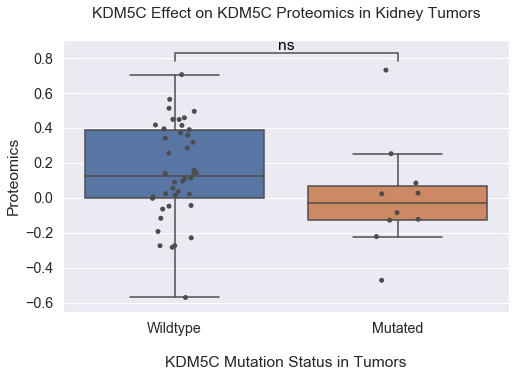

In [6]:
f.cis_plot(prot_mut_status, gene, "proteomics", prot_results)

Proteomics: Missense and Truncation compared to wildtype

In [7]:
prot_mut_type = f.get_missense_truncation_comparison(cancer, 'proteomics', gene)
prot_wildtype = prot_mut_status.loc[prot_mut_status['binary_mutations'] == 'Wildtype'] # select all wildtype 
prot_mut_and_wildtype = prot_mut_type.append(prot_wildtype, sort=False) # use for graph

In [8]:
# compare missense and wildtype
prot_miss_wt = prot_mut_and_wildtype.loc[prot_mut_and_wildtype['binary_mutations'] != 'Truncation']

print("Doing t-test comparison for missense and wildtype")
prot_results_miss = wrap_ttest_return_all(prot_miss_wt, 'binary_mutations', prot_col_list, cis_tests)
prot_results_miss = prot_results_miss.rename(index= {0: 'Missense/Wildtype'})
prot_results_miss

Doing t-test comparison for missense and wildtype


,Comparison,P_Value,Significant
Missense/Wildtype,KDM5C_proteomics,0.26845,False


In [9]:
# compare truncation and wildtype
prot_trunc_wt = prot_mut_and_wildtype.loc[prot_mut_and_wildtype['binary_mutations'] != 'Missense']

print("Doing t-test comparison for truncation and wildtype")
prot_results_trunc = wrap_ttest_return_all(prot_trunc_wt, 'binary_mutations', prot_col_list, cis_tests)
prot_results_trunc = prot_results_trunc.rename(index= {0: 'Truncation/Wildtype'})
prot_results_trunc

Doing t-test comparison for truncation and wildtype


,Comparison,P_Value,Significant
Truncation/Wildtype,KDM5C_proteomics,0.029263,False


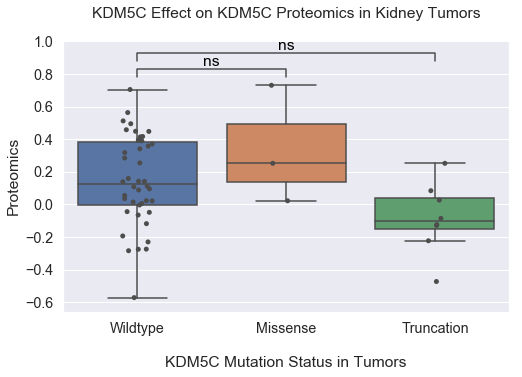

,Comparison,P_Value,Significant
Missense/Wildtype,KDM5C_proteomics,0.268450,False
Truncation/Wildtype,KDM5C_proteomics,0.029263,False


In [10]:
prot_results_miss_trunc = prot_results_miss.append(prot_results_trunc)
f.cis_plot(prot_mut_and_wildtype, gene, 'proteomics', prot_results_miss_trunc)

prot_results_miss_trunc

# Transcriptomics cis comparison

Transcriptomics: Mutated and Wildtype

In [22]:
trans_col_list = [gene+'_transcriptomics']
trans_col = gene+'_transcriptomics'
trans_mut_status = f.format_cis_comparison_data(cancer, 'transcriptomics', gene)

print("Doing t-test comparison for mutation status")
transcrpt_results = wrap_ttest_return_all(trans_mut_status, 'binary_mutations', trans_col_list)
transcrpt_results = transcrpt_results.rename(index = {0: "Mutated/Wildtype"})
transcrpt_results

Doing t-test comparison for mutation status


,Comparison,P_Value,Significant
Mutated/Wildtype,KDM5C_transcriptomics,0.000038,True


In [47]:
# different annotation 
#f.cis_plot(trans_mut_status, gene, 'transcriptomics', transcrpt_results)

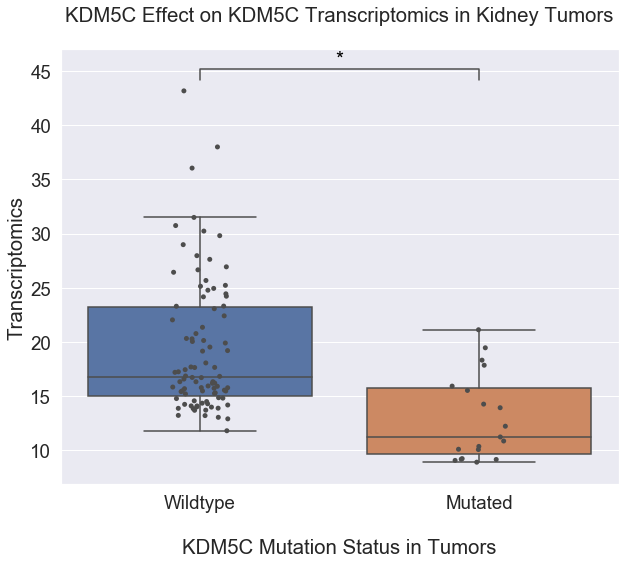

In [70]:
# 
plt.rcParams['figure.figsize']=(10,8)
sns.set(font_scale = 1.7)
cis_boxplot = sns.boxplot(data = trans_mut_status, x = 'binary_mutations',
                          y = trans_col, order = ['Wildtype', 'Mutated'], showfliers = False)  
cis_boxplot.set_title(gene + " Effect on " + gene +" Transcriptomics in Kidney Tumors\n")
cis_boxplot = sns.stripplot(data= trans_mut_status, x = 'binary_mutations',
                            y = trans_col,jitter = True, color = ".3", order = ['Wildtype', 'Mutated'])
cis_boxplot.set(xlabel = "\n"+gene + " Mutation Status in Tumors", ylabel = 'Transcriptomics')
cis_boxplot.set_xticklabels(cis_boxplot.get_xticklabels())

mut_pval_symbol = f.get_pval_symbol(transcrpt_results)
x1, x2 = 0, 1   # columns (first column: 0, see plt.xticks())
y, h = trans_mut_status[trans_col].max() + 1, 1   
plt.plot([x1, x1, x2, x2], #draw horizontal line
         [y, y+h, y+h, y], #vertical line
         lw=1.5, color= '.3')
plt.text((x1+x2)*.5, # half between x coord
         y+h, mut_pval_symbol, horizontalalignment='center', verticalalignment='bottom', color = "black")

plt.show()
plt.clf()
plt.close()

Transcriptomics: Missense and Truncation

In [13]:
# select all wildtype from earlier -add to mut_type binary column
trans_wildtype = trans_mut_status.loc[trans_mut_status['binary_mutations'] == 'Wildtype'] 
trans_mut_type = f.get_missense_truncation_comparison(cancer, 'transcriptomics', gene)
trans_mut_and_wildtype = trans_mut_type.append(trans_wildtype, sort=False) # use for graph

In [14]:
# compare missense and wildtype
miss_wt = trans_mut_and_wildtype.loc[trans_mut_and_wildtype['binary_mutations'] != 'Truncation']
print("Doing t-test comparison for missense and wildtype")
trans_results_miss = wrap_ttest_return_all(miss_wt, 'binary_mutations', trans_col_list)
trans_results_miss = trans_results_miss.rename(index = {0: "Missense/Wildtype"})
trans_results_miss

Doing t-test comparison for missense and wildtype


,Comparison,P_Value,Significant
Missense/Wildtype,KDM5C_transcriptomics,0.16179,False


In [15]:
# compare truncation and wildtype
trunc_wt = trans_mut_and_wildtype.loc[trans_mut_and_wildtype['binary_mutations'] != 'Missense']
print("Doing t-test comparison for truncation and wildtype")
trans_results_trunc = wrap_ttest_return_all(trunc_wt, 'binary_mutations', trans_col_list)
trans_results_trunc = trans_results_trunc.rename(index = {0: "Truncation/Wildtype"})
trans_results_trunc

Doing t-test comparison for truncation and wildtype


,Comparison,P_Value,Significant
Truncation/Wildtype,KDM5C_transcriptomics,0.000027,True


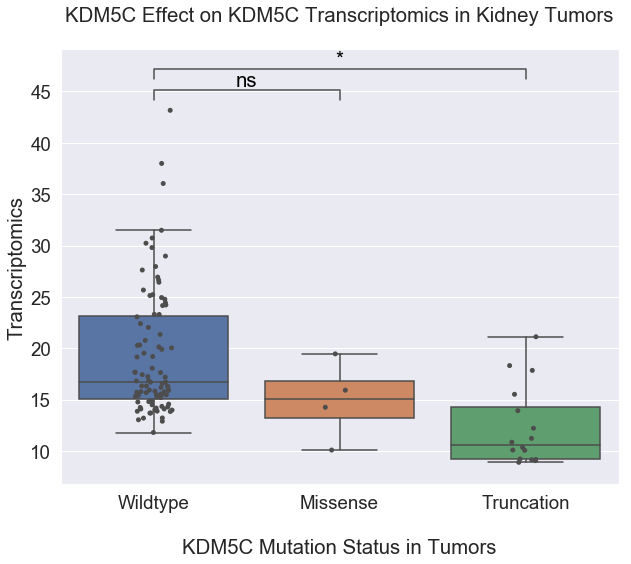

,Comparison,P_Value,Significant
Missense/Wildtype,KDM5C_transcriptomics,0.161790,False
Truncation/Wildtype,KDM5C_transcriptomics,0.000027,True


In [64]:
trans_results_miss_trunc = trans_results_miss.append(trans_results_trunc)
#f.cis_plot(trans_mut_and_wildtype, gene, 'transcriptomics', trans_results_miss_trunc)


plt.rcParams['figure.figsize']=(10,8)
sns.set(font_scale = 1.7)
cis_boxplot = sns.boxplot(data = trans_mut_and_wildtype, x = 'binary_mutations',
                          y = trans_col, order = ['Wildtype', 'Missense', 'Truncation'], showfliers = False)  
cis_boxplot.set_title(gene + " Effect on " + gene +" Transcriptomics in Kidney Tumors\n")
cis_boxplot = sns.stripplot(data= trans_mut_and_wildtype, x = 'binary_mutations',
                            y = trans_col,jitter = True, color = ".3", order = ['Wildtype', 'Missense', 'Truncation'])
cis_boxplot.set(xlabel = "\n"+gene + " Mutation Status in Tumors", ylabel = 'Transcriptomics')
cis_boxplot.set_xticklabels(cis_boxplot.get_xticklabels())


# Missense
miss_pval = trans_results_miss_trunc.loc[trans_results_miss_trunc.index == "Missense/Wildtype"]
miss_pval_symbol = f.get_pval_symbol(miss_pval)

x1, x2 = 0, 1   # columns (first column: 0, see plt.xticks())
y, h = trans_mut_and_wildtype[trans_col].max() + 1, 1  
plt.plot([x1, x1, x2, x2], #draw horizontal line
         [y, y+h, y+h, y], #vertical line
         lw=1.5, color= '.3')
plt.text((x1+x2)*.5, # half between x coord
         y+h, miss_pval_symbol, horizontalalignment='center', verticalalignment='bottom', color = "black")

# Truncation 
trunc_pval = trans_results_miss_trunc.loc[trans_results_miss_trunc.index == "Truncation/Wildtype"]
trunc_pval_symbol = f.get_pval_symbol(trunc_pval)

x3, x4 = 0, 2   # columns (first column: 0, see plt.xticks())
y2, h2 = trans_mut_and_wildtype[trans_col].max() + 3, 1    
plt.plot([x3, x3, x4, x4], #draw horizontal line
         [y2, y2+h2, y2+h2, y2], #vertical line
         lw=1.5, color= '.3')
plt.text((x3+x4)*.5, # half between x coord
         y2+h2, trunc_pval_symbol, horizontalalignment='center', verticalalignment='bottom', color = "black")

plt.show()
plt.clf()
plt.close()


trans_results_miss_trunc

# Phosphoproteomics cis comparison

Phosphoproteomics: Mutated and Wildtype

In [71]:
# Step 1 - Create dataframe in order to do comparisons with wrap_ttest
omics_and_mut = cancer.join_omics_to_mutations(
    mutations_genes = gene, omics_df_name = 'phosphoproteomics', omics_genes = gene)

# Step 2 - Create the binary column needed to do the comparison
omics_and_mut['binary_mutations'] = omics_and_mut[gene+'_Mutation_Status'].apply(
    lambda x: 'Wildtype' if x == 'Wildtype_Tumor' else 'Mutated')

# Step 3 - Format
omics_and_mut = omics_and_mut.query('Sample_Status != "Normal"') # changed because warning with slice
#tumors = omics_and_mut.loc[omics_and_mut['Sample_Status'] == 'Tumor'] #drop Normal samples
columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
binary_phospho = omics_and_mut.drop(columns_to_drop, axis = 1)
only_phospho = binary_phospho.drop('binary_mutations', axis = 1)
#omics_and_mut['binary_mutations'].value_counts()

In [259]:
# Use al.wrap_ttest for many columns of phospho data
phos_col_list = list(only_phospho.columns)

# Step 4 - T-test comparing means of mutated vs wildtype effect on cis omics
print("Doing t-test comparison for mutation status")
phos_pval_results = al.wrap_ttest(binary_phospho, 'binary_mutations', phos_col_list)
phos_pval_results['Significant'] = 'True'
phos_pval_results = phos_pval_results.rename(index = {0: "Mutated/Wildtype", 1: "Mutated/Wildtype"})
phos_pval_results

Doing t-test comparison for mutation status


,Comparison,P_Value,Significant
Mutated/Wildtype,KDM5C-T1357_phosphoproteomics,5.945912e-09,True
Mutated/Wildtype,KDM5C-S300_phosphoproteomics,1.957095e-05,True


Graph

In [202]:
# Create data frame with all significant phospho sites in order to graph
phospho_list = list(phos_pval_results['Comparison'])
phospho_df = pd.melt(binary_phospho, id_vars = 'binary_mutations', 
            value_vars = phospho_list, var_name = 'specific_phospho', value_name = 'phosphoproteomics')
phospho_df.replace(to_replace = '_phosphoproteomics', value = '', 
                        inplace = True, regex = True) # shorten column names
#sig_phospho_df.dropna(axis=0)

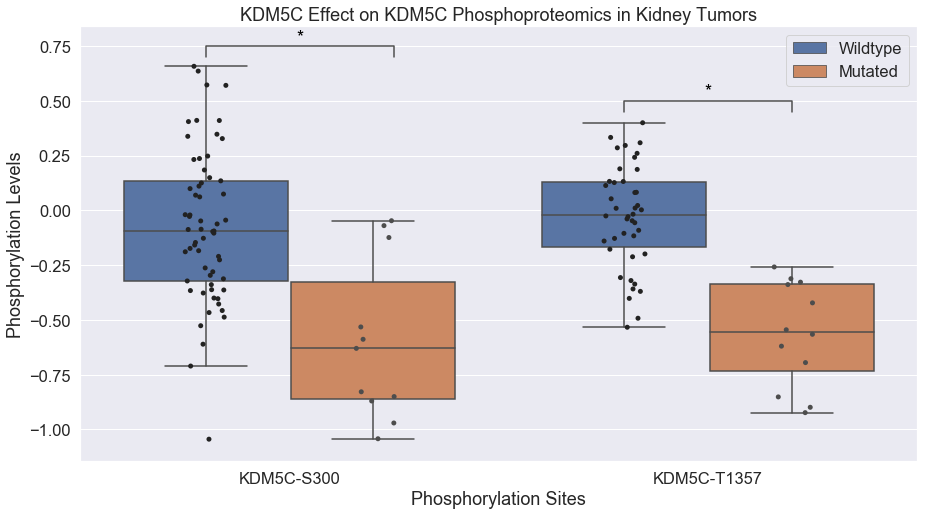

In [254]:
plt.rcParams['figure.figsize']=(15,8) #size of plot
sns.set(font_scale = 1.5)

cis_boxplot = sns.boxplot(data = phospho_df, x = 'specific_phospho', y = 'phosphoproteomics', hue = 'binary_mutations',
                             hue_order = ["Wildtype","Mutated"], order = ['KDM5C-S300', 'KDM5C-T1357'], showfliers = False) 
cis_boxplot.set_title(gene + " Effect on " + gene + " Phosphoproteomics in Kidney Tumors")
cis_boxplot = sns.stripplot(data = phospho_df, x = 'specific_phospho', y = 'phosphoproteomics',order = ['KDM5C-S300', 'KDM5C-T1357'], hue = 'binary_mutations',
                               hue_order = ["Wildtype","Mutated"], jitter = True, color = ".3", dodge = True)
cis_boxplot.set(xlabel = 'Phosphorylation Sites', ylabel = "Phosphorylation Levels")
cis_boxplot.set_xticklabels(cis_boxplot.get_xticklabels())

# format legend
handles, labels = cis_boxplot.get_legend_handles_labels()
plt.legend(handles[0:2], labels[0:2])

# pval annotations for KDM5C-S300
format_pval_annotation('*', x1 = -.2, x2 = .25, line_start = .7, line_height = .05)
# pval annotations for KDM5C-T1357
format_pval_annotation('*', x1 = .8, x2 = 1.2, line_start = .45, line_height = .05)

plt.show()
plt.clf()
plt.close()


Phosphoproteomics: Missense and Truncation

In [164]:
# select all wildtype from earlier -add to mut_type binary column
phos_wildtype = binary_phospho.loc[binary_phospho['binary_mutations'] == 'Wildtype'] 

phos_mut_type = f.get_missense_truncation_comparison(cancer, 'phosphoproteomics', gene)
phos_mut_and_wildtype = phos_mut_type.append(phos_wildtype, sort=True) 

In [261]:
phos_col_list = list(only_phospho.columns)
# compare missense and wildtype
miss_wt = phos_mut_and_wildtype.loc[phos_mut_and_wildtype['binary_mutations'] != 'Truncation']
print("Doing t-test comparison for missense and wildtype")
phos_results_miss = al.wrap_ttest(miss_wt, 'binary_mutations', phos_col_list)
phos_results_miss = phos_results_miss.dropna()
phos_results_miss = phos_results_miss.rename(index = {0 : 'Missense/Wildtype'})
phos_results_miss['Significant'] = 'True'

Doing t-test comparison for missense and wildtype


In [197]:
# compare truncation and wildtype 
trunc_wt = phos_mut_and_wildtype.loc[phos_mut_and_wildtype['binary_mutations'] != 'Missense']
print("Doing t-test comparison for truncation and wildtype")
phos_results_trunc = al.wrap_ttest(trunc_wt, 'binary_mutations', phos_col_list)
phos_results_trunc = phos_results_trunc.dropna()
phos_results_trunc = phos_results_trunc.rename(index = {0 : 'Truncation/Wildtype', 1: "Truncation/Wildtype"})
phos_results_trunc['Significant'] = 'True'

Doing t-test comparison for truncation and wildtype


In [198]:
phos_results_miss_trunc = phos_results_miss.append(phos_results_trunc)
phos_results_miss_trunc

,Comparison,P_Value,Significant
Missense/Wildtype,KDM5C-T1357_phosphoproteomics,1.025926e-03,True
Truncation/Wildtype,KDM5C-T1357_phosphoproteomics,1.790970e-08,True
Truncation/Wildtype,KDM5C-S300_phosphoproteomics,2.977410e-05,True


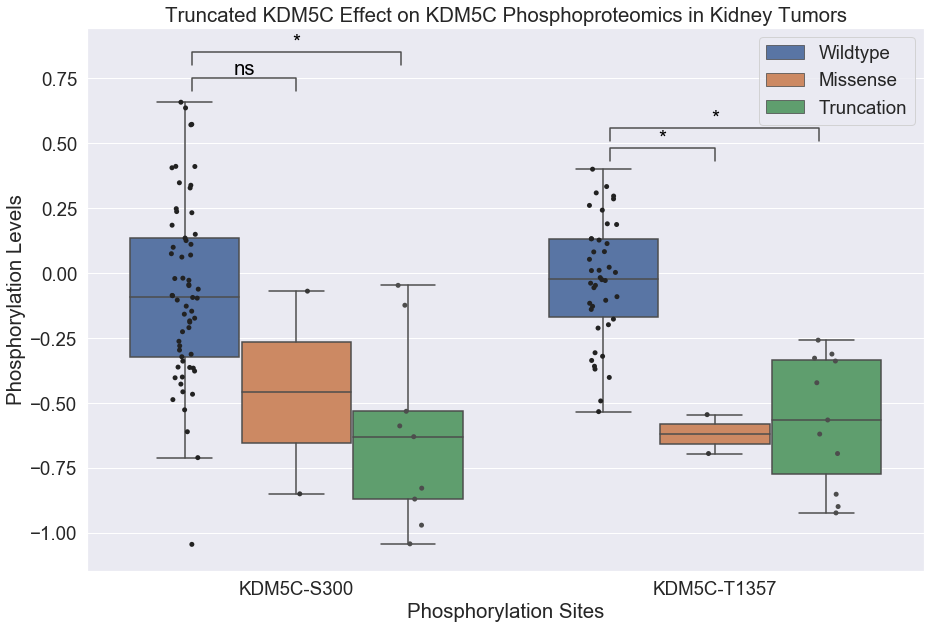

In [257]:
plt.rcParams['figure.figsize']=(15,10) #size of plot
sns.set(font_scale = 1.7)
phos_cis_boxplot = sns.boxplot(data = phos_df, x = 'specific_phospho', y = 'phosphoproteomics', order = ['KDM5C-S300', 'KDM5C-T1357'],
                               hue = 'binary_mutations', hue_order = ["Wildtype","Missense","Truncation"], showfliers = False)  
phos_cis_boxplot.set_title("Truncated "+gene + " Effect on " + gene + " Phosphoproteomics in Kidney Tumors")
phos_cis_boxplot = sns.stripplot(
    data = phos_df, x = 'specific_phospho', y = 'phosphoproteomics', order = ['KDM5C-S300', 'KDM5C-T1357'],
    hue = 'binary_mutations', hue_order = ["Wildtype","Missense","Truncation"], 
    jitter = True, color = ".3", dodge=True)
phos_cis_boxplot.set(xlabel = 'Phosphorylation Sites', ylabel = "Phosphorylation Levels")
phos_cis_boxplot.set_xticklabels(phos_cis_boxplot.get_xticklabels())

handles, labels = phos_cis_boxplot.get_legend_handles_labels()
plt.legend(handles[0:3], labels[0:3])

# pval annotations for KDM5C-S300
format_pval_annotation('ns',x1 = -.25, x2 = 0, line_start = .7, line_height = .05)
format_pval_annotation('*', x1 = -.25, x2 = .25, line_start = .8, line_height = .05)

# pval annotations for KDM5C-T1357
format_pval_annotation('*', x1 = .75, x2 = 1.25, line_start = .51, line_height = .05)
format_pval_annotation('*', x1 = .75, x2 = 1, line_start = .43, line_height = .05)

plt.show()
plt.clf()
plt.close()

# Analysis of Results

Significant cis comparisons: Transcriptomics significantly decreased with truncation mutations compared to the wildtype. Missense mutations followed the same trend (p-value not significant).
No significant effect on proteomics.
Phosphorylation levels significantly decreased for 2 sites with truncation mutations compared to the wildtype 

No acetylproteomics for the kidney dataset.